In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chocolate-data/Chocolate Sales (2).csv


#  **Analysis of Chocolate sales using SARIMA Time series model.** 

# Import necessary libraries and suppress warnings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import time

# Data Loading

In [3]:
# For splitting data and modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
df = pd.read_csv('/kaggle/input/chocolate-data/Chocolate Sales (2).csv')
df.head()


,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04/01/2022,"$5,320.00",180
1,Van Tuxwell,India,85% Dark Bars,01/08/2022,"$7,896.00",94
2,Gigi Bohling,India,Peanut Butter Cubes,07/07/2022,"$4,501.00",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27/04/2022,"$12,726.00",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24/02/2022,"$13,685.00",184


# Data Cleaning- Fixing Data types

In [4]:
df['Date_Fixed'] = pd.to_datetime(
    df['Date'],
    format='%m/%d/%Y',
    errors='coerce'
)
df['Month'] = df['Date_Fixed'].dt.month
df['Year'] = df['Date_Fixed'].dt.year
df['Amount'] = df['Amount'].replace({'\$': '', ',': ''}, regex=True)
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
dummy = df['Date_Fixed'].isnull()
df['dummy'] = dummy
df.head()

,Sales Person,Country,Product,Date,Amount,Boxes Shipped,Date_Fixed,Month,Year,dummy
0,Jehu Rudeforth,UK,Mint Chip Choco,04/01/2022,5320.0,180,2022-04-01,4.0,2022.0,False
1,Van Tuxwell,India,85% Dark Bars,01/08/2022,7896.0,94,2022-01-08,1.0,2022.0,False
2,Gigi Bohling,India,Peanut Butter Cubes,07/07/2022,4501.0,91,2022-07-07,7.0,2022.0,False
3,Jan Morforth,Australia,Peanut Butter Cubes,27/04/2022,12726.0,342,NaT,NaN,NaN,True
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24/02/2022,13685.0,184,NaT,NaN,NaN,True


In [5]:
#Changing date format to correct order (MM/DD/YYYY)
for i in df.index:
    if df.loc[i, 'dummy'] == True:
        # Convert incorrect DD/MM/YYYY to MM/DD/YYYY
        df.loc[i, 'Date'] = pd.to_datetime(
            df.loc[i, 'Date'],
            format='%d/%m/%Y',
            errors='coerce'
        ).strftime('%m/%d/%Y')
    else:
        # Ensure correct dates are standardized
        df.loc[i, 'Date'] = pd.to_datetime(
            df.loc[i, 'Date'],
            format='%m/%d/%Y',
            errors='coerce'
        ).strftime('%m/%d/%Y')

print("Missing dates:", df['Date'].isnull().sum())
df['Month'] = df['Date_Fixed'].dt.month
df['Year'] = df['Date_Fixed'].dt.year
df.head()

Missing dates: 0


,Sales Person,Country,Product,Date,Amount,Boxes Shipped,Date_Fixed,Month,Year,dummy
0,Jehu Rudeforth,UK,Mint Chip Choco,04/01/2022,5320.0,180,2022-04-01,4.0,2022.0,False
1,Van Tuxwell,India,85% Dark Bars,01/08/2022,7896.0,94,2022-01-08,1.0,2022.0,False
2,Gigi Bohling,India,Peanut Butter Cubes,07/07/2022,4501.0,91,2022-07-07,7.0,2022.0,False
3,Jan Morforth,Australia,Peanut Butter Cubes,04/27/2022,12726.0,342,NaT,NaN,NaN,True
4,Jehu Rudeforth,UK,Peanut Butter Cubes,02/24/2022,13685.0,184,NaT,NaN,NaN,True


# Generating Plots for better understanding

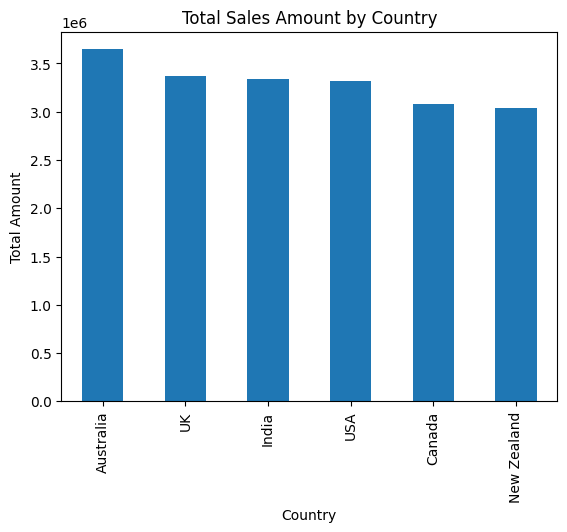

In [6]:
# Country-wise total Amount plot
# -----------------------------
country_totals = (
    df.groupby('Country')['Amount']
    .sum()
    .sort_values(ascending=False)
)

plt.figure()
country_totals.plot(kind='bar')
plt.title("Total Sales Amount by Country")
plt.xlabel("Country")
plt.ylabel("Total Amount")
plt.show()

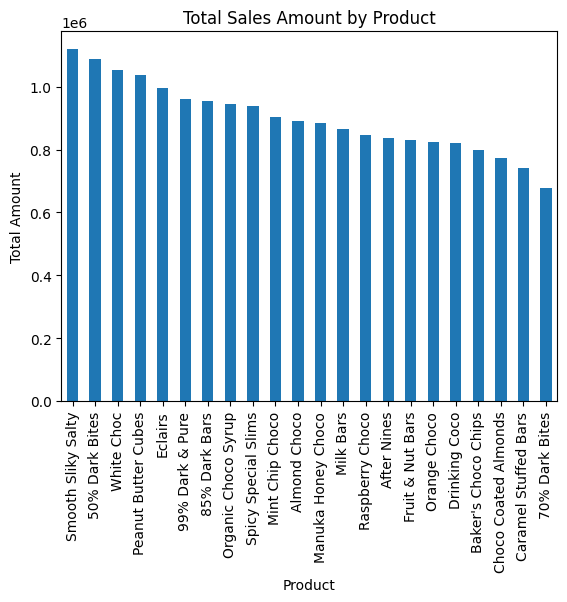

In [7]:
# Product-wise total Amount plot
# -----------------------------
country_totals = (
    df.groupby('Product')['Amount']
    .sum()
    .sort_values(ascending=False)
)

plt.figure()
country_totals.plot(kind='bar')
plt.title("Total Sales Amount by Product")
plt.xlabel("Product")
plt.ylabel("Total Amount")
plt.show()

YearMonth
2022-01-01    168728.0
2022-02-01    146097.0
2022-03-01    192059.0
2022-04-01    312487.0
2022-05-01    216132.0
Freq: MS, Name: Amount, dtype: float64


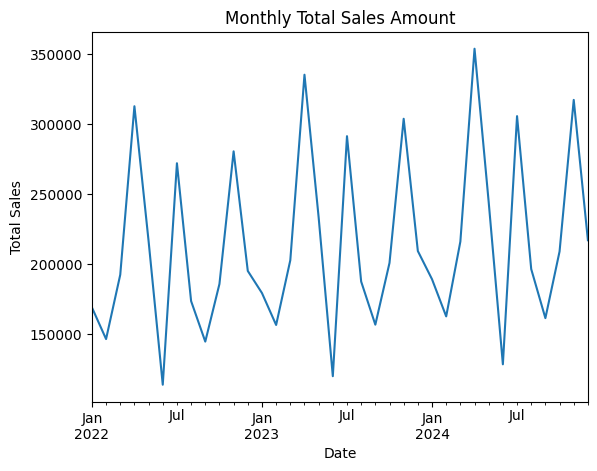

In [8]:
#Checking Monthly sales to identify seasonality
# Create Year-Month
df['YearMonth'] = df['Date_Fixed'].dt.to_period('M')

# Monthly total sales
monthly_sales = (
    df.groupby('YearMonth')['Amount']
    .sum()
    .to_timestamp()
)

print(monthly_sales.head())
plt.figure()
monthly_sales.plot()
plt.title("Monthly Total Sales Amount")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()

# Modeling SARIMA Time series model for forecasting

In [9]:
train = monthly_sales[:-8]
test = monthly_sales[-8:]

print("Train period:", train.index.min(), "to", train.index.max())
print("Test period:", test.index.min(), "to", test.index.max())

#Fit SARIMA model on training data
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit()

print(sarima_fit.summary())

Train period: 2022-01-01 00:00:00 to 2024-04-01 00:00:00
Test period: 2024-05-01 00:00:00 to 2024-12-01 00:00:00
                                     SARIMAX Results                                      
Dep. Variable:                             Amount   No. Observations:                   28
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  -9.673
Date:                            Thu, 05 Feb 2026   AIC                             29.347
Time:                                    17:01:05   BIC                             19.347
Sample:                                01-01-2022   HQIC                              -inf
                                     - 04-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a

# Evaluating Model

In [10]:
#Forecast and evaluate
forecast_res = sarima_fit.get_forecast(steps=len(test))

forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int(alpha=0.01)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("SARIMA MAE:", mae)
print("SARIMA RMSE:", rmse)

SARIMA MAE: 14904.902022482349
SARIMA RMSE: 15355.88484986098


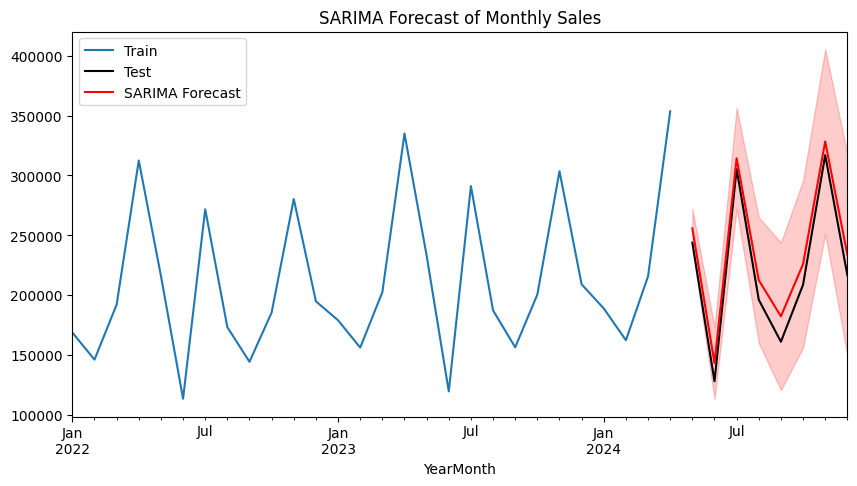

In [11]:
#SARIMA Forecast for Test sample
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

train.plot(label='Train')
test.plot(label='Test', color='black')
forecast.plot(label='SARIMA Forecast', color='red')

plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='red',
    alpha=0.2
)

plt.title("SARIMA Forecast of Monthly Sales")
plt.legend()
plt.show()



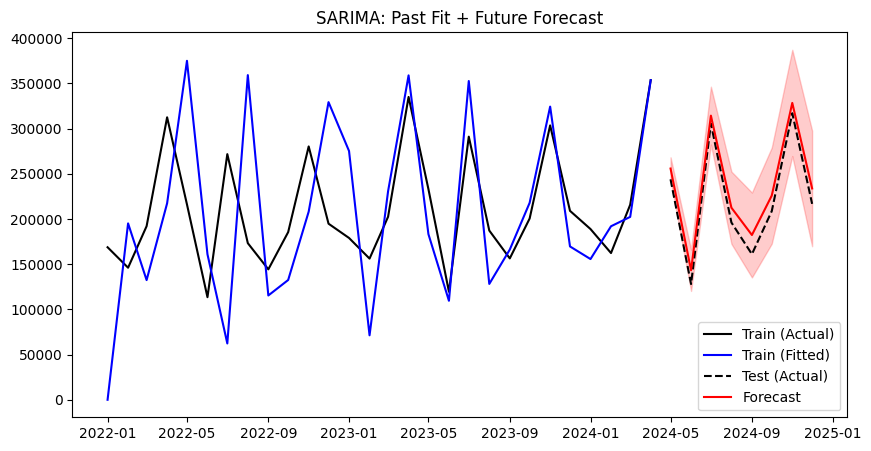

In [12]:
# Total Actual Vs Forecast graph
forecast_res = sarima_fit.get_forecast(steps=len(test))
forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

plt.figure(figsize=(10, 5))
# In-sample predictions (past data)
fitted_values = sarima_fit.fittedvalues
plt.plot(train.index, train, label='Train (Actual)', color='black')
plt.plot(train.index, fitted_values, label='Train (Fitted)', color='blue')

plt.plot(test.index, test, label='Test (Actual)', color='black', linestyle='--')
plt.plot(forecast.index, forecast, label='Forecast', color='red')

plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='red',
    alpha=0.2
)

plt.title("SARIMA: Past Fit + Future Forecast")
plt.legend()
plt.show()


# Forecast Values Vs Actual

In [13]:
final_forecast = sarima_fit.get_forecast(steps=5)
forecast_vs_actual = pd.DataFrame({
    'Actual': test.iloc[:5],
    'Forecast': final_forecast.predicted_mean.iloc[:5],

})
# Extract confidence intervals for the 5 steps of final_forecast
conf_int_df = final_forecast.conf_int()
forecast_vs_actual['Lower CI'] = conf_int_df['lower Amount']
forecast_vs_actual['Upper CI'] = conf_int_df['upper Amount']

print(forecast_vs_actual)

               Actual       Forecast       Lower CI       Upper CI
2024-05-01  243882.62  255799.990421  243377.222128  268222.758713
2024-06-01  128049.01  143260.097415  120374.393129  166145.801702
2024-07-01  305412.97  314324.933886  282293.275362  346356.592410
2024-08-01  196108.69  212474.356101  172503.411547  252445.300656
2024-09-01  161053.85  182268.493390  135327.696315  229209.290465
